# Run Preprocess Session

This notebook runs the preprocessing pipeline from `src.preprocess`.

Workflow:
1. Select a remote session folder with a GUI dialog.
2. Prepare local output and copy `basename.xml`.
3. Build `chanMap.mat` from XML with probe assignments.
4. Run `run_preprocess_session(config)` (preprocess + sorting when `sorter` is set).
5. Sorting output folder is automatically named as `SorterName_YYYY-MM-DD_HHMMSS` (e.g. `Kilosort_2026-02-16_120658`).


In [23]:
%reload_ext autoreload
%autoreload 2
from pathlib import Path

from src.preprocess import (
    PreprocessConfig,
    prepare_chanmap,
    run_preprocess_session,
    select_paths_with_gui,
    show_chanmap,
)


## 1) Select Basepath And Prepare XML (GUI)


In [ ]:
# Choose one mode:
# 1) GUI mode: use_gui=True
# 2) Manual mode: use_gui=False and set manual_basepath
# use_gui = True
# manual_basepath = None  # e.g. r'T:\\data\\AutoMaze\\RM010\\RM010_day43_20250925'

# basepath, basename, local_output_dir, xml_path = select_paths_with_gui(
#     use_gui=use_gui,
#     manual_basepath=manual_basepath,
#     initial_drive=r'S:\\',
#     local_root=Path.cwd() / 'sorting_temp',
# )

# print('basepath      :', basepath)
# print('basename      :', basename)
# print('local_output  :', local_output_dir)
# print('xml_path      :', xml_path)


use_gui = False
manual_basepath = "/local/workdir/ys2375/data/ayadataB4/data/theta_replay/Sake/sake_day24"

basepath, basename, local_output_dir, xml_path = select_paths_with_gui(
    use_gui=use_gui,
    manual_basepath=manual_basepath,
    initial_drive=r'S:\\',
    local_root=Path.cwd() / 'sorting_temp',
)

print('basepath      :', basepath)
print('basename      :', basename)
print('local_output  :', local_output_dir)
print('xml_path      :', xml_path)

## 2) Define Probe Assignments

`groups` are XML group indices (0-based).
`type` can be: `double_sided`, `staggered`, `poly3`, `poly5`, `NeuroPixel`, `neurogrid`.


In [ ]:
# Single double-sided probe example:
probe_assignments = [
    {'type': 'double_sided', 'groups': [0, 1, 2, 3, 4, 5, 6, 7], 'x_offset': 0},
]

probe_assignments


[{'type': 'double_sided', 'groups': [0, 1, 2, 3, 4, 5, 6, 7], 'x_offset': 0}]

## 3) Generate `chanMap.mat`


Successfully saved chanMap.mat to /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/chanMap.mat
chanMap path           : /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/chanMap.mat
bad channels (0-based) : [8, 10, 21, 26, 34, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


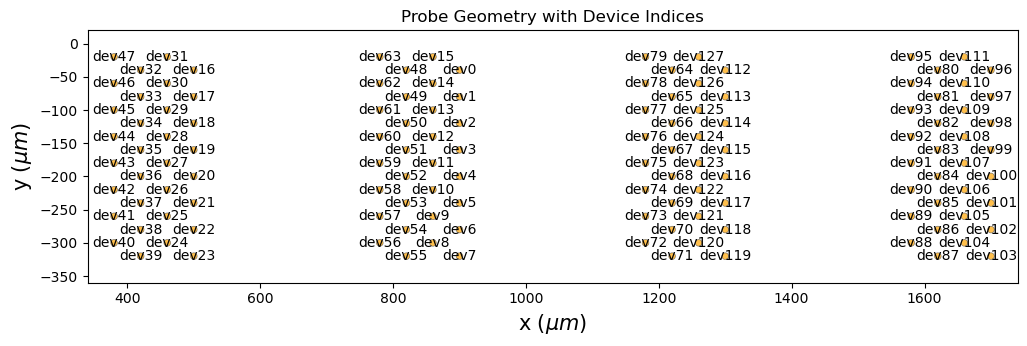

bad channels from plot : [8, 10, 21, 26, 34, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [ ]:
chanmap_path, bad_ch_ids = prepare_chanmap(
    basepath=basepath,
    basename=basename,
    local_output_dir=local_output_dir,
    probe_assignments=probe_assignments,
    reject_channels=[],
)

print('chanMap path           :', chanmap_path)
print('bad channels (0-based) :', bad_ch_ids)

# Visualize generated channel map (same style as Spike_sorting_KS1.ipynb)
bad_ch_ids_plot = show_chanmap(chanmap_path)
print('bad channels from plot :', bad_ch_ids_plot)


## 4) Build Preprocess Config


In [ ]:
pre_config = PreprocessConfig(
    basepath=basepath,
    localpath=local_output_dir.parent,

    sort_files=True,
    alt_sort=None,
    ignore_folders=[],

    do_preprocess=True,
    bandpass_min_hz=500.0,
    bandpass_max_hz=8000.0,
    reference='local',
    local_radius_um=(50.0, 200.0),

    make_lfp=True,
    lfp_fs=1250,
    state_score=True,            
    sw_channels=None,            
    theta_channels=None,
    state_block_wake_to_rem = True,  # Optionally block wake to REM transitions 
    state_min_state_length=6.0, 
    emg_th_alpha = 1,  # EMG threshold alpha for state scoring (higher = more stringent)

    analog_inputs=False,
    analog_channels=None,
    digital_inputs=True,
    digital_channels=None,

    chanmap_mat_path=chanmap_path,
    reject_channels=[],

    # basename.dat is exported as preprocessed data by default.
    # save_raw=True additionally writes basename_raw.dat (unprocessed concat).
    save_raw=False,
    export_intermediate_dat=True,

    sorter='kilosort4',
    sorter_config_path=Path("sorter") / "Kilosort4_config.yaml",
    # sorter='Kilosort',
    # sorter_path=Path('sorter') / 'KiloSort1',
    # sorter_config_path=Path('sorter') / 'Kilosort1_config.yaml',

    # If matlab is not on PATH, set explicit executable path here:
    matlab_path=Path('/local/workdir/ys2375/MATLAB/R2024b/bin/matlab'),

    overwrite=False,
    save_params_json=True,
    save_manifest_json=True,
    save_log_mat=True,

    job_kwargs = {
        "pool_engine": "process",
        "n_jobs": 256,
        # "chunk_duration": "10s",          
        "progress_bar": True,
        "max_threads_per_worker": 1,  
    }
)

pre_config


PreprocessConfig(basepath=PosixPath('/fs/ayadata2-afr77.nbb.cornell.edu/volume4/ayadataB4/data/theta_replay/Sake/sake_day04'), localpath=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp'), output_dir=None, sort_files=True, alt_sort=None, ignore_folders=[], dtype='int16', gain_to_uV=0.195, offset_to_uV=0.0, do_preprocess=True, bandpass_min_hz=500.0, bandpass_max_hz=8000.0, reference='local', local_radius_um=(50.0, 200.0), make_lfp=True, lfp_fs=1250, session_basepath_mode='local', state_score=True, sw_channels=None, theta_channels=None, state_ignore_manual=False, state_save_lfp_mat=True, state_sticky_trigger=False, state_winparms=(2.0, 15.0), emg_th_alpha=1, state_min_state_length=6.0, state_block_wake_to_rem=True, analog_inputs=False, analog_channels=None, digital_inputs=True, digital_channels=None, chanmap_mat_path=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/chanMap.mat'), reject_channels=[], save_raw=False, export_intermediate_dat=True, 

## 5) Run Preprocess


In [ ]:
from dataclasses import replace
from src import use_existing_sorting, make_post_recording, run_postprocess_session


do_sorting = True
existing_sorting_dir = None

runtime_config = pre_config if do_sorting else replace(pre_config, sorter=None, save_raw=True)
result = run_preprocess_session(runtime_config)
if not do_sorting:
    result = use_existing_sorting(
        result,
        sorter=pre_config.sorter,
        existing_sorting_dir=existing_sorting_dir,
    )
    recording_for_post = make_post_recording(result, pre_config)
else:
    recording_for_post = None

result


Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 16 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensor channels.


kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 20445440
kilosort.run_kilosort: N seconds: 1022.272
kilosort.run_kilosort: N batches: 171


Loaded sorter params: /local/workdir/ys2375/PreprocessPipeline/sorter/Kilosort4_config.yaml
Resolved Kilosort4 params
Skipping sorter-side preprocessing/channel exclusion: using preprocessed binary input as-is
Applied Kilosort4 probe-geometry params: dmin=None, dminx=40.0, max_channel_distance=50.0, nearest_chans=16, whitening_range=32, x_centers=4
Running sorter=kilosort4 -> /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/Kilosort4_2026-02-27_175248
Skipping common average reference.


kilosort.run_kilosort: Preprocessing filters computed in 0.27s; total 0.27s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     9.10 %
kilosort.run_kilosort: Mem used:      7.60 %     |     171.40 GB
kilosort.run_kilosort: Mem avail:    2095.40 / 2266.81 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   10.49 %     |      9.96   /    94.97 GB
kilosort.run_kilosort: Allocated:     0.01 %     |      0.01   /    94.97 GB
kilosort.run_kilosort: Max alloc:     5.54 %     |      5.26   /    94.97 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: -------------------------------

kilosort4 run time 146.70s
Patched output metadata for raw.dat compatibility: n_channels_dat=128, active=128
Sorter finished


PreprocessResult(basepath=PosixPath('/fs/ayadata2-afr77.nbb.cornell.edu/volume4/ayadataB4/data/theta_replay/Sake/sake_day04'), basename='sake_day04', local_output_dir=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04'), dat_path=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/sake_day04.dat'), lfp_path=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/sake_day04.lfp'), session_mat_path=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/sake_day04.session.mat'), mergepoints_mat_path=PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/sake_day04.MergePoints.events.mat'), analog_event_paths=[], digital_event_paths=[PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/digitalIn.events.mat')], intermediate_dat_paths={'digitalin': PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day04/digitalin.dat'), 'auxiliary': PosixPa

In [68]:
# # you can run state scoring separately 
# from dataclasses import replace
# from scipy.io import loadmat

# from src.preprocess.io import resolve_basepath_and_basename, resolve_local_output_dir
# from src.preprocess.state_scoring import run_state_scoring

# basepath, basename = resolve_basepath_and_basename(pre_config.basepath)
# output_dir = resolve_local_output_dir(basepath, basename, pre_config)

# session_struct = loadmat(output_dir / f"{basename}.session.mat", simplify_cells=True)["session"]

# pulses = None
# pulses_path = output_dir / f"{basename}.pulses.events.mat"
# if pulses_path.exists():
#     d = loadmat(pulses_path, simplify_cells=True)
#     if isinstance(d.get("pulses"), dict):
#         pulses = d["pulses"]

# state_cfg = replace(pre_config, state_score=True, overwrite=True)

# state_result = run_state_scoring(
#     basepath=output_dir,
#     basename=basename,
#     session_struct=session_struct,
#     pulses=pulses,
#     config=state_cfg,
# )

## 6) Quick Check


In [7]:
print('local_output_dir      :', result.local_output_dir)
print('dat_path              :', result.dat_path)  # preprocessed basename.dat
raw_dat_path = result.local_output_dir / f"{result.basename}_raw.dat"
print('raw_dat_path          :', raw_dat_path if raw_dat_path.exists() else None)
print('lfp_path              :', result.lfp_path)
print('session_mat_path      :', result.session_mat_path)
print('mergepoints_mat_path  :', result.mergepoints_mat_path)
print('intermediate_dat_paths:', result.intermediate_dat_paths)
print('n_channels            :', result.n_channels)
print('sr                    :', result.sr)
print('sr_lfp                :', result.sr_lfp)
print('bad_channels_0based   :', result.bad_channels_0based)
print('sorter                :', result.sorter)
print('sorter_output_dir     :', result.sorter_output_dir)


local_output_dir      : /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23
dat_path              : /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/sake_day23.dat
lfp_path              : /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/sake_day23.lfp
session_mat_path      : /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/sake_day23.session.mat
mergepoints_mat_path  : /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/sake_day23.MergePoints.events.mat
intermediate_dat_paths: {'digitalin': PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/digitalin.dat'), 'auxiliary': PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/auxiliary.dat'), 'time': PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/time.dat')}
n_channels            : 128
sr                    : 20000.0
sr_lfp                : 1250
bad_channels_0based   : [8, 10, 21, 26, 34, 64

In [8]:

import spikeinterface.extractors as se 
sorting_KS1 = se.read_phy(Path("/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/Kilosort_2026-02-19_121712") / 'sorter_output')
sorting_KS4 = se.read_phy(Path("/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/Kilosort4_2026-02-26_233911") / 'sorter_output')
sorting_KS4_2 = se.read_phy(Path("/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day23/Kilosort4_2026-02-27_004603") / 'sorter_output')

In [ ]:
sorting_KS1, sorting_KS4, sorting_KS4_2

(PhySortingExtractor: 583 units - 1 segments - 20.0kHz,
 PhySortingExtractor: 140 units - 1 segments - 20.0kHz,
 PhySortingExtractor: 207 units - 1 segments - 20.0kHz)

: 

## 7) Run Postprocess
Runs postprocessing pipeline and exports `sorter_output_postprocessed` under each Kilosort run.


In [ ]:
# from src import PostprocessConfig
# if result.sorter_output_dir is None:
#     raise RuntimeError("No sorter output found. Set result.sorter_output_dir first.")

# sorting_phy_folder = Path(result.sorter_output_dir) / "sorter_output"

# post_cfg = PostprocessConfig(
#     sorting_phy_folder=sorting_phy_folder,

#     # Input recording source (either recording OR dat_path)
#     recording=recording_for_post,          # or None
#     dat_path=result.dat_path,              # used when recording is None
#     sampling_frequency=result.sr,
#     num_channels=result.n_channels,
#     dtype=pre_config.dtype,
#     gain_to_uV=pre_config.gain_to_uV,
#     offset_to_uV=pre_config.offset_to_uV,
#     chanmap_mat_path=pre_config.chanmap_mat_path,
#     reject_channels=pre_config.reject_channels,

#     # Preprocess behavior when dat_path is used
#     apply_preprocessing_if_dat=True,
#     preprocess_recording_object=False,
#     bandpass_min_hz=pre_config.bandpass_min_hz,
#     bandpass_max_hz=pre_config.bandpass_max_hz,
#     reference=pre_config.reference,
#     local_radius_um=pre_config.local_radius_um,

#     # Sorting read / dedup
#     exclude_cluster_groups=["noise", "mua"],
#     duplicate_censored_period_ms=0.5,
#     duplicate_threshold=0.5,
#     remove_strategy="max_spikes",

#     # Analyzer cache
#     # During processing, intermediate waveforms/PCs are stored in
#     #   <KilosortDir>/sorter_output_postprocessed_analyzer_cache/
#     # (separate from the Phy output folder to avoid Windows file-lock issues).
#     # delete_analyzer_cache=True  → cache is deleted at the end (only Phy folder remains)
#     # delete_analyzer_cache=False → cache is kept; set skip_curation=True to restart from cache
#     analyzer_format="binary_folder",
#     analyzer_cache_dir=None,
#     delete_analyzer_cache=False,   # set False to keep cache when skip_curation=True
#     skip_curation=False,           # True → skip dedup/merge/split and reuse cached split analyzer
#     n_components=5,
#     pc_mode="by_channel_local",

#     # Merge
#     merge_min_spikes=100,
#     merge_corr_diff_thresh=0.25,
#     merge_template_diff_thresh=0.25,
#     merge_sparsity_overlap=0.5,
#     merge_censor_ms=0.5,

#     # Split
#     split_contamination=0.05,
#     split_threshold_mode="adaptive_chi2",
#     split_min_clean_frac=0.9,
#     split_relax_factor=0.5,
#     split_use_waveform_gate=True,
#     split_wf_threshold=0.3,
#     split_wf_template_max=1000,
#     split_wf_n_chans=10,
#     split_wf_center="demean",
#     split_squeeze_all_outlier_to_new=True,
#     split_min_spikes=10,
#     split_verbose=True,

#     # Metrics
#     metric_names=["isi_violation", "presence_ratio", "snr", "amplitude_median"],
#     skip_pc_metrics=True,

#     # Output
#     output_folder_name="sorter_output_postprocessed",
#     remove_if_exists=True,
#     copy_binary=False,
#     phy_hp_filtered=True,
#     # use_relative_path: controls how dat_path is written in Phy's params.py.
#     #   False → absolute path (safe across drives, recommended)
#     #   True  → path relative to the output folder (portable if folder is moved together with dat)
#     use_relative_path=False,
#     metrics_csv_name="quality_metrics.csv",

#     # dat_path written into Phy params.py:
#     #   write_preprocessed_dat_for_phy=True  → a freshly exported filtered .dat is used
#     #   force_params_dat_path=Path(...)      → explicit override
#     #   otherwise (both None)               → dat_path above (basename.dat) is used automatically
#     write_preprocessed_dat_for_phy=False,
#     force_params_dat_path=None,

#     # Noise labeling
#     noise_thresholds = {
#         "isi_violations_ratio_gt": 5.0,
#         "isi_violations_count_gt": 50.0,
#         "presence_ratio_lt": 0.1,
#         "snr_lt": 0.3,
#         "amplitude_median_lt": 25.0,
#         "firing_rate_lt": 0.01,  # Hz
#     },
#     noise_backup=False,

#     # Parallel settings for postprocess
#     # chunk_duration is important on Windows: prevents pipe overflow when spawning workers
#     job_kwargs = {
#         "pool_engine": "process",
#         "n_jobs": -1,                   
#         "progress_bar": True,
#         "max_threads_per_worker": 1,  
#     }
# )


In [ ]:
# post_result = run_postprocess_session(post_cfg)

[postprocess] start run_postprocess_session()
[postprocess] sorting_phy_folder=/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day02/Kilosort_2026-02-25_210618/sorter_output
[postprocess] output_folder=/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day02/Kilosort_2026-02-25_210618/sorter_output_postprocessed
[postprocess] analyzer_cache_dir=/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day02/Kilosort_2026-02-25_210618/sorter_output_postprocessed_analyzer_cache
[postprocess] recording resolved
[postprocess] loading Phy sorting
[postprocess] loaded sorting: n_units=599, total_spikes=1560531
[postprocess] removing duplicated spikes
[postprocess] after dedup: n_units=599 (delta=0), total_spikes=1550783 (removed=9748)
[postprocess] removing redundant units
[postprocess] after remove_redundant_units: n_units=573 (removed=26), total_spikes=1475374
[postprocess] computing merge/split features


estimate_sparsity (workers: 512 processes):   0%|          | 0/2405 [00:00<?, ?it/s]

compute_waveforms (workers: 512 processes):   0%|          | 0/2405 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/573 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/573 [00:00<?, ?it/s]

[postprocess] computing merge candidates
[postprocess] merge candidates: 1 groups
[postprocess] mergeable groups: 1
[postprocess] merging units
[postprocess] running auto split (verbose=True)
unit 0 (orig): keep 73 clean | split 39 outliers
unit 1 (orig): keep 8887 clean | split 1438 outliers
unit 2 (orig): keep 2869 clean | split 588 outliers
unit 4 (orig): keep 3562 clean | split 392 outliers
unit 5 (orig): keep 1201 clean | split 869 outliers
unit 6 (orig): keep 16391 clean | split 5265 outliers
unit 7 (orig): keep 160 clean | split 82 outliers
unit 8 (orig): keep 539 clean | split 224 outliers
unit 10 (orig): keep 1177 clean | split 732 outliers
unit 12 (orig): keep 144 clean | split 55 outliers
unit 13 (orig): keep 159 clean | split 34 outliers
unit 14 (orig): keep 482 clean | split 271 outliers
unit 15 (orig): keep all (18 spikes)
unit 16 (orig): keep 30957 clean | split 620 outliers
unit 17 (orig): keep 25964 clean | split 739 outliers
unit 18 (orig): keep 2359 clean | split 737

estimate_sparsity (workers: 512 processes):   0%|          | 0/2405 [00:00<?, ?it/s]

compute_waveforms (workers: 512 processes):   0%|          | 0/2405 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/724 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/724 [00:00<?, ?it/s]

/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/postprocessing/template_metrics.py:644: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = scipy.stats.linregress(times[peak_idx:max_idx], template_single[peak_idx:max_idx])


Compute : spike_amplitudes + spike_locations (workers: 512 processes):   0%|          | 0/2405 [00:00<?, ?it/s…

[postprocess] computing quality metrics
[postprocess] exporting to Phy


extract PCs (workers: 512 processes):   0%|          | 0/2405 [00:00<?, ?it/s]

Run:
phy template-gui  /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day02/Kilosort_2026-02-25_210618/sorter_output_postprocessed/params.py
[postprocess] fixing params.py dat_path/hp_filtered
[postprocess] marking noise clusters from metrics
[postprocess] done: n_units_final=724, total_spikes_final=1474703, n_noise_clusters=78
